# CNNで学習する

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, Dropout
from sklearn.model_selection import train_test_split

In [3]:
images = [] # 画像データの配列
labels = [] # すべての正解ラベルの配列
class_name = ['healthy','disease'] # すべてのクラス名

# 1. 画像データのパスを読み込む

In [4]:
# 画像データのパスを読み込む
data_healthy = glob.glob("data/mfcc_spectrogram_images/healthy/*") # 健常者のデータ
data_bad     = glob.glob("data/mfcc_spectrogram_images/disease/*") # 疾患のある人のデータ

# 2. データセットを作る

In [5]:
# データセットを作る
for i in range(len(data_healthy)): # 健常者のデータ
  X = np.array((Image.open(data_healthy[i])).resize((224,224))) # 画像データをopenしてリサイズしてnumpy配列にする
  images.append(X) # 画像データを追加
  labels.append([1,0]) # 正解ラベルを追加 One-Hotベクトル

for i in range(len(data_bad)): # 疾患のある人のデータ
  X = np.array((Image.open(data_bad[i])).resize((224,224)))
  images.append(X) # 画像データを追加
  labels.append([0,1]) # 正解ラベルを追加 One-Hotベクトル

In [6]:
# numpy配列にする
images = np.array(images)
labels = np.array(labels)

In [7]:
# データの正規化
images = images.astype('float32') / 255.0 # 0~1に丸める

# 3. トレーニングデータとテストデータに分ける

In [8]:
# test_size - テストデータの割合を0~1の範囲で指定する 0.33で33%
# random_state - 乱数シードを指定してデータの振り分けを固定する
# データはシャッフルされる
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, random_state=111)

# 4. CNNモデルを構築する

In [9]:
# CNNモデルを構築
#「Conv2D」を使って「畳み込みニューラルネットワーク」CNNを実装
model = Sequential()

# Conv2D(特徴マップ数, カーネルサイズ, ...)
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_images.shape[1:])) # 畳み込み層 カーネルサイズ3x3, 特徴マップ32枚
model.add(Activation('relu')) # 活性化関数ReLUを使用する
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2)) # クラスは2個
model.add(Activation('softmax'))

## 4.1 コンパイルする

In [10]:
# コンパイル
model.compile(loss="categorical_crossentropy",
            optimizer="SGD",
            metrics=[
                "accuracy",
                keras.metrics.Recall(),
                keras.metrics.Precision()
            ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      1

In [11]:
# 学習する 出力はなしで設定(verbose=0)
# epochs - 学習回数
history = model.fit(train_images, train_labels, batch_size=10, epochs=200, validation_data=(test_images, test_labels))

Epoch 1/200
8/8 [==============================] - 15s 2s/step - loss: 0.7217 - accuracy: 0.4545 - recall: 0.4545 - precision: 0.4545 - val_loss: 0.7081 - val_accuracy: 0.4474 - val_recall: 0.4474 - val_precision: 0.4474
Epoch 2/200
8/8 [==============================] - 14s 2s/step - loss: 0.7048 - accuracy: 0.4545 - recall: 0.4545 - precision: 0.4545 - val_loss: 0.6931 - val_accuracy: 0.4474 - val_recall: 0.4474 - val_precision: 0.4474
Epoch 3/200
8/8 [==============================] - 13s 2s/step - loss: 0.6960 - accuracy: 0.4935 - recall: 0.4935 - precision: 0.4935 - val_loss: 0.6936 - val_accuracy: 0.4474 - val_recall: 0.4474 - val_precision: 0.4474
Epoch 4/200
8/8 [==============================] - 13s 2s/step - loss: 0.6829 - accuracy: 0.5455 - recall: 0.5455 - precision: 0.5455 - val_loss: 0.6898 - val_accuracy: 0.4474 - val_recall: 0.4474 - val_precision: 0.4474
Epoch 5/200
8/8 [==============================] - 14s 2s/step - loss: 0.7025 - accuracy: 0.4805 - recall: 0.4805 - 

In [12]:
# 学習モデル保存
model.save("CNN.h5")

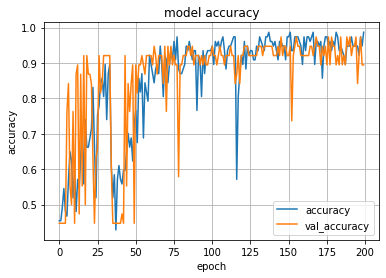

In [18]:
# 正解率の算出
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.grid(True)
#plt.savefig("accuracy.jpg")
plt.show()

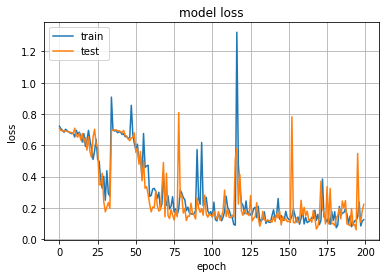

In [14]:
# 損失率の算出
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
#plt.savefig("loss.jpg")
plt.show()

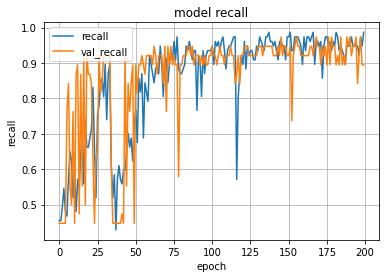

In [19]:
# 適合率の算出（予測したもののうち、実際のものと正しく予測できた割合）
plt.plot(history.history["recall"])
plt.plot(history.history["val_recall"])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['recall', 'val_recall'], loc='upper left')
plt.grid(True)
plt.show()

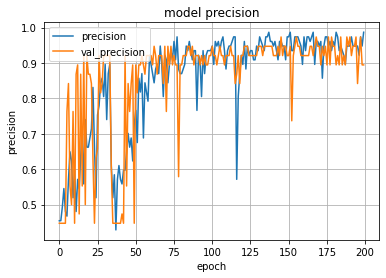

In [20]:
# 再現率の算出（実際のもののうち、正しく予測できた割合）
plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['precision', 'val_precision'], loc='upper left')
plt.grid(True)
plt.show()

In [17]:
# 正解率の評価
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("Test Accuracy:", test_acc)

2/2 - 1s - loss: 0.2223 - accuracy: 0.8947 - recall: 0.8947 - precision: 0.8947


ValueError: too many values to unpack (expected 2)

In [ ]:
# 予測する
predictions = model.predict(test_images)
print(predictions[0]) # 1枚目のテストデータの予測